#### Face Identity Classification
This example illustrates MIA attacks on a face identity classfier model. The classfier is train on [CelebA Mask HQ](https://github.com/switchablenorms/CelebAMask-HQ) dataset which should be downloaded, decompressed, and placed in the ```data``` directory as follows:

directory_structure:

```
data/
    ├── train/
    │   ├── identity 1/
    │   ├── identity 2/
    │   └── ...
    └── test/
        ├── identity 1/
        ├── identity 2/
        └── ...
```


In [3]:
import os

# Path to the dataset zip file
zip_path = "./data/CelebA_HQ_facial_identity_dataset.zip"
data_folder = "./data"

# Check if the 'data' folder exists, if not, create it
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
    print("'data' folder created.")

# Check if the file already exists
if not os.path.exists(zip_path):
    print("Dataset not found. Downloading...")
    !wget -O {zip_path} https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ES-jbCNC6mNHhCyR4Nl1QpYBlxVOJ5YiVerhDpzmoS9ezA?download=1 
    !unzip {zip_path} -d ./data
    print("Download and extraction completed.")
else:
    print("Dataset already exists.")

Dataset not found. Downloading...
--2025-01-19 12:12:09--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ES-jbCNC6mNHhCyR4Nl1QpYBlxVOJ5YiVerhDpzmoS9ezA?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/datasets/CelebA_HQ_facial_identity_dataset.zip?ga=1 [following]
--2025-01-19 12:12:11--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/datasets/CelebA_HQ_facial_identity_dataset.zip?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 552776581 (527M) [application/x-zip-compressed]
Saving to: ‘./data/CelebA_HQ_facial_identity_dataset.zip’

### Train the Identity Classifier Model

In [4]:
import os
import sys
import yaml

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(project_root)

In [5]:
from examples.mia.celebA_HQ.utils.celeb_hq_data import get_celebA_hq_dataloader
from examples.mia.celebA_HQ.utils.celeb_hq_model import ResNet18, create_trained_model_and_metadata

# Load the config.yaml file
with open('train_config.yaml', 'r') as file:
    train_config = yaml.safe_load(file)

# Generate the dataset and dataloaders
path = os.path.join(os.getcwd(), train_config["data"]["data_dir"])

In [4]:
train_loader, test_loader = get_celebA_hq_dataloader(path, train_config)

Load data from ./data/celeba_hq_data.pkl


In [5]:
num_classes =307

model = ResNet18(num_classes = num_classes)
train_acc, train_loss, test_acc, test_loss = create_trained_model_and_metadata(model,train_loader,test_loader, train_config)

Training Progress: 100%|██████████| 30/30 [01:32<00:00,  3.07s/it]


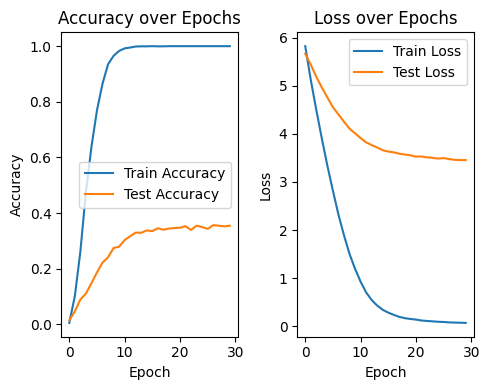

In [6]:
import matplotlib.pyplot as plt

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

### MIA Attacks on Identifier Model 

In [7]:
from celebA_HQ_handler import CelebAHQInputHandler

from leakpro import LeakPro

# Read the config file
config_path = "audit.yaml"

# Prepare leakpro object
leakpro = LeakPro(CelebAHQInputHandler, config_path)

# Run the audit 
mia_results = leakpro.run_audit(return_results=True)

2025-01-18 17:56:32,474 INFO     Target model blueprint created from ResNet18 in ./utils/celeb_hq_model.py.
2025-01-18 17:56:32,475 INFO     Loaded target model metadata from ./target/model_metadata.pkl


Configurations: {'audit': {'random_seed': 1234, 'attack_list': {'rmia': {'training_data_fraction': 0.5, 'attack_data_fraction': 0.5, 'num_shadow_models': 3, 'online': True, 'temperature': 2, 'gamma': 2.0, 'offline_a': 0.33, 'offline_b': 0.66}}, 'output_dir': './leakpro_output', 'attack_type': 'mia', 'modality': 'image'}, 'target': {'module_path': './utils/celeb_hq_model.py', 'model_class': 'ResNet18', 'target_folder': './target', 'data_path': './data/celeba_hq_data.pkl'}, 'shadow_model': None, 'distillation_model': None}


/home/fazeleh/LeakPro/leakpro/input_handler/handler_setup.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.target_model.load_state_dict(torch.load(f))
2025-01-18 17

### Report Generating

In [8]:
# Import and initialize ReportHandler
from leakpro.reporting.report_handler import ReportHandler

# report_handler = ReportHandler()
report_handler = ReportHandler(report_dir="./leakpro_output/results")

# Save MIA resuls using report handler
for res in mia_results:
    report_handler.save_results(attack_name=res.attack_name, result_data=res, config=res.configs)

# # Create the report by compiling the latex text
report_handler.create_report()

2025-01-18 18:02:11,107 INFO     Initializing report handler...
2025-01-18 18:02:11,108 INFO     report_dir set to: ./leakpro_output/results
2025-01-18 18:02:11,109 INFO     Saving results for rmia
2025-01-18 18:02:20,962 INFO     No results of type GIAResults found.
2025-01-18 18:02:20,964 INFO     No results of type SinglingOutResults found.
2025-01-18 18:02:20,964 INFO     No results of type InferenceResults found.
2025-01-18 18:02:20,965 INFO     No results of type LinkabilityResults found.
2025-01-18 18:02:26,134 INFO     PDF compiled


<Figure size 640x480 with 0 Axes>